# Fashion MNIST Classification with PyTorch

A simple neural network built with PyTorch to classify clothing images from the Fashion MNIST dataset.

This project covers:

- Loading and handlding Fashion MNIST dataset
- Building a sequential fully connected network
- Saving and loading trained models

#### 1. Import PyTorch and load a sample dataset


In [2]:
import torch as pt
import numpy as np

Load [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) data from github

In [5]:
!rm -rf data
!git clone https://github.com/zalandoresearch/fashion-mnist data

Cloning into 'data'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 762 (delta 0), reused 0 (delta 0), pack-reused 760 (from 2)
Receiving objects: 100% (762/762), 105.85 MiB | 3.48 MiB/s, done.
Resolving deltas: 100% (444/444), done.


#### 2. Dataset handling: Traditional way with scikit-learn

In [6]:
!cat data/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [7]:
import os
os.listdir('data/data/fashion')

['t10k-images-idx3-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'train-labels-idx1-ubyte.gz',
 't10k-labels-idx1-ubyte.gz']

In [8]:
# import mnist_reader:
import data.utils.mnist_reader as mnist_reader

In [9]:
# load data:
X_train_full, y_train_full = mnist_reader.load_mnist('data/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

In [10]:
type(X_train_full)

numpy.ndarray

In [11]:
X_train_full.shape, X_test.shape

((60000, 784), (10000, 784))

In [12]:
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [13]:
X_train_full.dtype

dtype('uint8')

In [14]:
# Introduced in the coursebook
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [15]:
X_test = X_test / 255.

#### 3. Stratified Split

In [20]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# normalize:
X_train_full = X_train_full / 255.

# split data:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=y_train_full
)

In [21]:
print("Train shape:", X_train.shape, y_train.shape)
print("Valid shape:", X_valid.shape, y_valid.shape)

Train shape: (30000, 784) (30000,)
Valid shape: (30000, 784) (30000,)


In [22]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [30]:
# Use the numeric label to get the class name, e.g:
class_names[0]

'T-shirt/top'

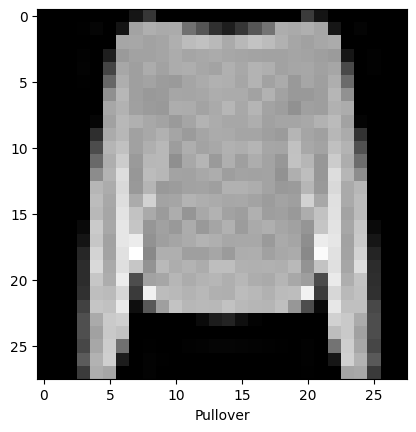

In [33]:
# see each data instance by using  plt.imshow.

import matplotlib.pyplot as plt
i = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[i].reshape((28, 28)), cmap='gray') # cmap to make it recognize grayscale
plt.xlabel(class_names[y_train[i]])
plt.show()

#### 4. Optimizing memory consuption using pipelines; use [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) API.

In [34]:
from numpy.typing import NDArray
from typing import Tuple
from torch.utils.data import Dataset

class FashionMNIST(Dataset):
  def __init__(self, X:NDArray[np.int8], y:NDArray[np.int8]) -> None:
    # normalize:
    self.X = X.astype(np.float32) / 255.0
    self.y = y

  def __len__(self) -> int:
    return len(self.y)

  def __getitem__(self, idx:int) -> int:
    return self.X[idx], self.y[idx]

  @staticmethod
  def create_split(fraction_train:float, fraction_validation:float, fraction_test:float) -> Tuple[Dataset, Dataset, Dataset]:
    assert fraction_train + fraction_validation + fraction_test == 1.0

    # load data:
    train = mnist_reader.load_mnist('data/data/fashion', kind='train')
    t10k  = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

    data   = np.concatenate((train[0], t10k[0]), axis=0)
    labels = np.concatenate((train[1], t10k[1]), axis=0)

    # split data:
    n = len(labels)
    n_train = int(n * fraction_train)
    n_validation = int(n * fraction_validation)

    data_train = FashionMNIST(
        data[:n_train],
        labels[:n_train]
    )
    data_valid = FashionMNIST(
        data[n_train:n_train+n_validation],
        labels[n_train:n_train+n_validation]
    )
    data_test = FashionMNIST(
        data[n_train+n_validation:],
        labels[n_train+n_validation:]
    )

    return data_train, data_valid, data_test

In [35]:
data, _, _ = FashionMNIST.create_split(.7, .1, .2)

In [36]:
# call to __len__:
len(data)

49000

In [37]:
# call to __getitem__:
data[5]

(array([0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.        , 0.        , 0.        , 0.08627451,
        0.34509805, 0.7372549 , 0.6745098 , 0.5176471 , 0.49019608,
        0.5529412 , 0.78039217, 0.56078434, 0.03529412, 0.        ,
        0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00392157, 0.        , 0.        , 0.07843138,
        0.5137255 , 0.78039217, 0.80784315, 0.76862746, 0.7921569 ,
        0.9490196 , 1.        , 1.        , 0.98039216, 0.87058824,
        0.77254903, 0.80784315, 0.7372549 , 0.49411765, 0.06666667,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.13725491, 0.8392157 , 0.7490196 , 0.7176471 ,
        0.69803923, 0.6862745 , 0.65882355, 0.5882353 , 0.63529414,
        0.62352943, 0.59607846, 0.61960787, 0.70

In [38]:
"""
But the above implementation still loads everything at the time of instantiation of the `FashionMNIST` class. 
Transform data
"""

target_dir = 'data/data/fashion/unzipped'
os.makedirs(target_dir, exist_ok=True)

train = mnist_reader.load_mnist('data/data/fashion', kind='train')
t10k  = mnist_reader.load_mnist('data/data/fashion', kind='t10k')

data = np.concatenate((train[0], t10k[0]), axis=0)
labels = np.concatenate((train[1], t10k[1]), axis=0)

for i, x in enumerate(data):
  file = os.path.join(target_dir, f'img_{i:d}.npy')
  with open(file, 'wb') as f:
    np.save(f, x.reshape((28, 28)))

with open(os.path.join(target_dir, 'labels.npy'), 'wb') as f:
  np.save(f, labels)

In [39]:
os.listdir(target_dir)[:10]

['img_10994.npy',
 'img_47614.npy',
 'img_8027.npy',
 'img_48527.npy',
 'img_7314.npy',
 'img_50368.npy',
 'img_21591.npy',
 'img_57407.npy',
 'img_11452.npy',
 'img_31782.npy']

In [40]:
class FashionMNIST(Dataset):

    def __init__(self, indices: NDArray[np.int32], labels: NDArray[np.int8]) -> None:
        self.indices = indices
        self.labels = labels

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        index = self.indices[idx]
        img_path = os.path.join(target_dir, f'img_{index}.npy')
        image = np.load(img_path).astype(np.float32) / 255.0
        label = self.labels[idx]
        return image, label

    @staticmethod
    def create_split(
        fraction_train: float,
        fraction_validation: float,
        fraction_test: float,
        stratify: bool = True,
        shuffle: bool = True
    ) -> Tuple[Dataset, Dataset, Dataset]:

        assert fraction_train + fraction_validation + fraction_test == 1.0

        labels = np.load(os.path.join(target_dir, 'labels.npy'))
        indices = np.arange(len(labels))

        frac_rest = fraction_validation + fraction_test

        indices_train, indices_rest, labels_train, labels_rest = train_test_split(
            indices,
            labels,
            test_size=frac_rest,
            stratify=labels if stratify else None,
            shuffle=shuffle
        )

        relative_frac_valid = fraction_validation / (fraction_validation + fraction_test)

        indices_valid, indices_test, labels_valid, labels_test = train_test_split(
            indices_rest,
            labels_rest,
            test_size=1 - relative_frac_valid,
            stratify=labels_rest if stratify else None,
            shuffle=shuffle
        )

        data_train = FashionMNIST(indices_train.astype(np.int32), labels_train)
        data_valid = FashionMNIST(indices_valid.astype(np.int32), labels_valid)
        data_test  = FashionMNIST(indices_test.astype(np.int32),  labels_test)

        return data_train, data_valid, data_test

**Shuffling and batching**: Using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [41]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

In [42]:
data_train, data_valid, data_test = FashionMNIST.create_split(.7, .1, .2)

In [43]:
loader_train = DataLoader(data_train,             # dataset from which to load the data.
                          batch_size=BATCH_SIZE,  # how many samples per batch to load (default: 1).
                          shuffle=True,           # set to True to have the data reshuffled at every epoch (default: False).
                          sampler=None,           # defines the strategy to draw samples from the dataset. Can be any Iterable with __len__ implemented.
                                                  # If specified, shuffle must not be specified.
                          batch_sampler=None,     # like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.
                          drop_last=False)        # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size.
                                                  # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

In [44]:
# validation set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_valid = DataLoader(data_valid,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

In [45]:
# test set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
loader_test  = DataLoader(data_test,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          sampler=None,
                          batch_sampler=None,
                          drop_last=False)

#### 5. Sequential fully connected network

#### Instantiating the network:

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(in_features=784, out_features=100, bias=True)
        self.layer2 = nn.Linear(in_features=100, out_features=len(class_names), bias=True)

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        x = F.relu(self.layer1(x))
        return F.softmax(self.layer2(x), dim=-1)

In [47]:
import torchinfo
from torchinfo import summary

model = CustomNetwork()
summary(model, input_size=(784,), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
CustomNetwork                            [10]                      --
├─Linear: 1-1                            [100]                     78,500
├─Linear: 1-2                            [10]                      1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.86
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

In [48]:
list(model.children())

[Linear(in_features=784, out_features=100, bias=True),
 Linear(in_features=100, out_features=10, bias=True)]

In [49]:
list(model.named_children())

[('layer1', Linear(in_features=784, out_features=100, bias=True)),
 ('layer2', Linear(in_features=100, out_features=10, bias=True))]

In [50]:
model.get_submodule('layer1')

Linear(in_features=784, out_features=100, bias=True)

In [51]:
# All modules in the model (including itself):
list(model.named_modules())

[('',
  CustomNetwork(
    (layer1): Linear(in_features=784, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=10, bias=True)
  )),
 ('layer1', Linear(in_features=784, out_features=100, bias=True)),
 ('layer2', Linear(in_features=100, out_features=10, bias=True))]

In [52]:
# You can get a generator object of parameters (weights) for each submodule using `parameters()`:
# !!! in order of instantiation !!!
list(model.parameters())[:2]

[Parameter containing:
 tensor([[ 0.0189,  0.0112, -0.0060,  ...,  0.0284, -0.0342,  0.0065],
         [ 0.0020,  0.0333, -0.0080,  ...,  0.0033, -0.0289,  0.0017],
         [ 0.0147, -0.0099, -0.0169,  ...,  0.0156, -0.0191,  0.0299],
         ...,
         [-0.0184, -0.0222, -0.0122,  ..., -0.0340, -0.0323, -0.0045],
         [-0.0037,  0.0048,  0.0130,  ..., -0.0290,  0.0350,  0.0349],
         [-0.0327, -0.0048, -0.0139,  ...,  0.0318,  0.0155, -0.0301]],
        requires_grad=True),
 Parameter containing:
 tensor([ 3.2583e-02, -9.6580e-03,  4.8409e-03,  6.3706e-03,  3.4219e-02,
          6.6762e-03,  9.9596e-04, -2.7098e-02, -3.1364e-02,  1.7978e-02,
          2.6231e-02, -3.5469e-02,  2.8918e-03,  2.5047e-02, -1.3822e-02,
         -2.6234e-02,  2.0192e-02, -3.1844e-02, -8.7521e-03,  2.1286e-02,
         -1.1650e-02,  7.1379e-03, -1.4292e-03, -3.2990e-02, -2.4752e-02,
         -3.0863e-02, -3.3917e-02,  6.2383e-03, -1.6859e-02,  6.5904e-03,
          2.1018e-02, -3.1571e-02, -2.85

In [53]:
list(model.named_parameters())[:2]

[('layer1.weight',
  Parameter containing:
  tensor([[ 0.0189,  0.0112, -0.0060,  ...,  0.0284, -0.0342,  0.0065],
          [ 0.0020,  0.0333, -0.0080,  ...,  0.0033, -0.0289,  0.0017],
          [ 0.0147, -0.0099, -0.0169,  ...,  0.0156, -0.0191,  0.0299],
          ...,
          [-0.0184, -0.0222, -0.0122,  ..., -0.0340, -0.0323, -0.0045],
          [-0.0037,  0.0048,  0.0130,  ..., -0.0290,  0.0350,  0.0349],
          [-0.0327, -0.0048, -0.0139,  ...,  0.0318,  0.0155, -0.0301]],
         requires_grad=True)),
 ('layer1.bias',
  Parameter containing:
  tensor([ 3.2583e-02, -9.6580e-03,  4.8409e-03,  6.3706e-03,  3.4219e-02,
           6.6762e-03,  9.9596e-04, -2.7098e-02, -3.1364e-02,  1.7978e-02,
           2.6231e-02, -3.5469e-02,  2.8918e-03,  2.5047e-02, -1.3822e-02,
          -2.6234e-02,  2.0192e-02, -3.1844e-02, -8.7521e-03,  2.1286e-02,
          -1.1650e-02,  7.1379e-03, -1.4292e-03, -3.2990e-02, -2.4752e-02,
          -3.0863e-02, -3.3917e-02,  6.2383e-03, -1.6859e-02, 

In [54]:
model.get_parameter('layer1.weight')

Parameter containing:
tensor([[ 0.0189,  0.0112, -0.0060,  ...,  0.0284, -0.0342,  0.0065],
        [ 0.0020,  0.0333, -0.0080,  ...,  0.0033, -0.0289,  0.0017],
        [ 0.0147, -0.0099, -0.0169,  ...,  0.0156, -0.0191,  0.0299],
        ...,
        [-0.0184, -0.0222, -0.0122,  ..., -0.0340, -0.0323, -0.0045],
        [-0.0037,  0.0048,  0.0130,  ..., -0.0290,  0.0350,  0.0349],
        [-0.0327, -0.0048, -0.0139,  ...,  0.0318,  0.0155, -0.0301]],
       requires_grad=True)

#### 6. Train the Network

In [55]:
class CustomNetwork(nn.Module):
    def __init__(self, dropout: float = 0.2) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 300)       # Linear-1
        self.do1 = nn.Dropout(dropout)       # Dropout-2
        self.fc2 = nn.Linear(300, 200)       # Linear-3
        self.do2 = nn.Dropout(dropout)       # Dropout-4
        self.fc3 = nn.Linear(200, 10)        # Linear-5

    def forward(self, x: pt.Tensor) -> pt.Tensor:
        x = F.relu(self.fc1(x))
        x = self.do1(x)
        x = F.relu(self.fc2(x))
        x = self.do2(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

**Alternative but more restrictive:** `torch.nn.Sequential`

In [56]:
from torch.nn import Sequential
from collections import OrderedDict

Unnamed layers:

In [57]:
model = Sequential(
    nn.Linear(in_features=784, out_features=100, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=len(class_names), bias=True),
    nn.Softmax(dim=-1)
)

Named layers:

In [58]:
model = Sequential(OrderedDict([
    ('layer1',      nn.Linear(in_features=784, out_features=100, bias=True)),
    ('activation1', nn.ReLU()),
    ('layer1',      nn.Linear(in_features=100, out_features=len(class_names), bias=True)),
    ('activation2', nn.Softmax(dim=-1))
]))

In [59]:
"""
- `cpu`: any of your computer's CPUs
- `cpu:0`:the first of your computer's CPUs
- `cuda`: any of your computer's GPUs
- `cuda:2`: the third GPU of you computer
"""
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
device

device(type='cpu')

In [61]:
model = CustomNetwork().to(device)

Prediction on new instances:

In [62]:
model.eval()

X_new = pt.tensor(X_test[:3], dtype=pt.float32).to(device)

with pt.no_grad():
    y_proba = model(X_new).detach().cpu().numpy()

y_proba

array([[0.09696269, 0.10422643, 0.10185836, 0.09539992, 0.10084123,
        0.0924779 , 0.10415525, 0.10475571, 0.10471357, 0.09460896],
       [0.09350897, 0.09706323, 0.10463558, 0.0983207 , 0.101381  ,
        0.09309861, 0.10345621, 0.10625675, 0.10098932, 0.10128968],
       [0.09644572, 0.10098576, 0.09974542, 0.0966524 , 0.104523  ,
        0.09678673, 0.10017651, 0.10433339, 0.10514128, 0.09520982]],
      dtype=float32)

In [63]:
np.array(class_names)[np.argmax(y_proba, axis=1)] 

array(['Sneaker', 'Sneaker', 'Bag'], dtype='<U11')

define a training procedure:

In [66]:
import pandas as pd
from sklearn.metrics import f1_score
from typing import Optional, Callable

In [67]:
def epoch(model:CustomNetwork, loader_train:DataLoader, optimizer:pt.optim.Optimizer, loss_fn:Callable[[pt.Tensor, pt.Tensor], pt.Tensor]):
  # 1. set model to train:
  model.train()

  losses = None if loss_fn is None else []
  with pt.enable_grad():
    for X_batch, y_batch in loader_train:
      # move tensors to correct device:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      # flatten input
      X_batch = X_batch.view(X_batch.size(0), -1)

      # reset all gradients to zero:
      optimizer.zero_grad()

      # create predictions:
      y_pred = model(X_batch)

      # calculate loss:
      loss = loss_fn(y_pred, y_batch)
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

      # backpropagate loss:
      loss.backward()

      # update weights:
      optimizer.step()

  return np.mean(losses)

In [68]:
def evaluate(model:CustomNetwork, loader_valid:DataLoader, loss_fn:Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]]=None):
  # 1. set model to eval:
  model.eval()

  labels = []
  predictions = []
  losses = None if loss_fn is None else []
  for X_batch, y_batch in loader_valid:
    # move tensors to correct device:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    labels.extend(y_batch.cpu().detach().numpy())

    # flatten
    X_batch = X_batch.view(X_batch.size(0), -1)


    # create predictions:
    y_pred = model(X_batch)
    predictions.extend(y_pred.cpu().detach().numpy())

    # calculate loss:
    if loss_fn is not None:
      losses.append(loss_fn(y_pred, y_batch).detach().cpu().numpy())

  # calculate f1 score:
  f1 = f1_score(
    y_batch.cpu().detach().numpy(),
    y_pred.argmax(dim=1).cpu().detach().numpy(),
    average='macro'
  )

  if loss_fn is None: return {'f1':f1}
  else: return {'loss':np.mean(losses), 'f1':f1}

In [69]:
def fit(model:CustomNetwork, loader_train:DataLoader, loader_valid:DataLoader, epochs:int, lr:float):
  # instantiate optimizer:
  optimizer = pt.optim.SGD(model.parameters(), lr=lr)

  # instantiate loss function:
  loss_fn = pt.nn.CrossEntropyLoss()

  history = []
  for i in range(epochs):
    # train for one epoch:
    loss_train = epoch(model, loader_train, optimizer, loss_fn)

    # evaluate on validation:
    metrics = evaluate(model, loader_valid, loss_fn)

    # save metrics:
    history.append({
      'loss_train':loss_train,
      'loss_valid': metrics['loss'],
      'f1_valid': metrics['f1']
    })

    # print message:
    print(f'Epoch {i+1:d}/{epochs:d}:', *[f'{metric} = {history[-1][metric]:.2f};' for metric in history[-1]], sep='\t')

  # return history:
  return pd.DataFrame(history)

Fit the model for 30 epochs:

Epoch 1/30:	loss_train = 2.29;	loss_valid = 2.27;	f1_valid = 0.20;
Epoch 2/30:	loss_train = 2.18;	loss_valid = 2.02;	f1_valid = 0.40;
Epoch 3/30:	loss_train = 1.94;	loss_valid = 1.86;	f1_valid = 0.55;
Epoch 4/30:	loss_train = 1.86;	loss_valid = 1.83;	f1_valid = 0.55;
Epoch 5/30:	loss_train = 1.83;	loss_valid = 1.81;	f1_valid = 0.55;
Epoch 6/30:	loss_train = 1.81;	loss_valid = 1.78;	f1_valid = 0.67;
Epoch 7/30:	loss_train = 1.79;	loss_valid = 1.77;	f1_valid = 0.67;
Epoch 8/30:	loss_train = 1.77;	loss_valid = 1.76;	f1_valid = 0.67;
Epoch 9/30:	loss_train = 1.76;	loss_valid = 1.75;	f1_valid = 0.67;
Epoch 10/30:	loss_train = 1.76;	loss_valid = 1.75;	f1_valid = 0.67;
Epoch 11/30:	loss_train = 1.75;	loss_valid = 1.74;	f1_valid = 0.67;
Epoch 12/30:	loss_train = 1.75;	loss_valid = 1.74;	f1_valid = 0.67;
Epoch 13/30:	loss_train = 1.74;	loss_valid = 1.74;	f1_valid = 0.67;
Epoch 14/30:	loss_train = 1.74;	loss_valid = 1.73;	f1_valid = 0.67;
Epoch 15/30:	loss_train = 1.74;	loss_valid = 1.73;	f1_val

<Axes: xlabel='epoch', ylabel='loss'>

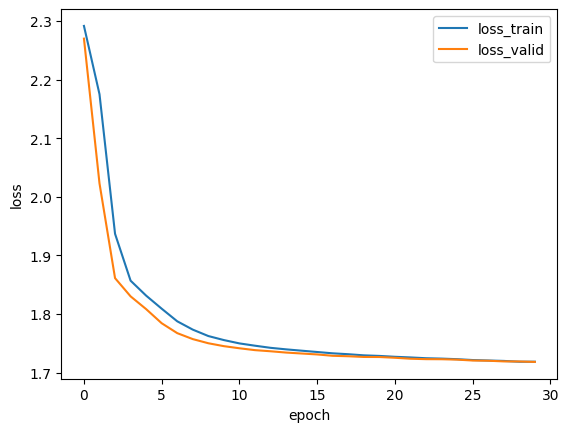

In [70]:
# instantiate model and move to device:
model = CustomNetwork().to(device)

# train model:
history = fit(model, loader_train, loader_valid, epochs=30, lr=.01)

# plot history:
history[['loss_train', 'loss_valid']].plot(xlabel='epoch', ylabel='loss')

#### 7. Evaluation

In [71]:
evaluate(model, loader_test) #evaluate on the test set

{'f1': 0.6338624338624339}

#### 8. Improve Training

In [72]:
def epoch(model: CustomNetwork, loader_train: DataLoader, optimizer: pt.optim.Optimizer, loss_fn: Callable[[pt.Tensor, pt.Tensor], pt.Tensor]):
    model.train()
    for xb, yb in loader_train:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate(model: CustomNetwork, loader_valid: DataLoader, loss_fn: Optional[Callable[[pt.Tensor, pt.Tensor], pt.Tensor]] = None):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with pt.no_grad():
        for xb, yb in loader_valid:
            preds = model(xb)
            if loss_fn is not None:
                loss = loss_fn(preds, yb)
                losses.append(loss.item())
            y_true.append(yb)
            y_pred.append(preds.argmax(dim=1))

    y_true = pt.cat(y_true).cpu().numpy()
    y_pred = pt.cat(y_pred).cpu().numpy()

    f1 = f1_score(y_true, y_pred, average='macro')
    avg_loss = np.mean(losses) if losses else None
    return avg_loss, f1
  
    
def fit(model: CustomNetwork, loader_train: DataLoader, loader_valid: DataLoader, epochs: int, lr: float, patience: int):
    optimizer = pt.optim.Adam(model.parameters(), lr=lr)

    scheduler = pt.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=0.33,
        total_iters=10
    )

    loss_fn = nn.CrossEntropyLoss()
    best_model = None
    best_loss = float('inf')
    wait = 0

    history = []

    for epoch_idx in range(epochs):
        epoch(model, loader_train, optimizer, loss_fn)
        val_loss, val_f1 = evaluate(model, loader_valid, loss_fn)

        history.append({'epoch': epoch_idx, 'val_loss': val_loss, 'val_f1': val_f1})

        if val_loss is not None and val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

        if epoch_idx < 10:
            scheduler.step()

    if best_model is not None:
        model.load_state_dict(best_model)

    return pd.DataFrame(history)  

#### 9. If we want to save and load the model with PyTorch

In [73]:
pt.save(model, 'model.pt')

In [74]:
model = pt.load('model.pt', weights_only=False)
summary(model, input_size=(1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
CustomNetwork                            [1, 10]                   --
├─Linear: 1-1                            [1, 300]                  235,500
├─Dropout: 1-2                           [1, 300]                  --
├─Linear: 1-3                            [1, 200]                  60,200
├─Dropout: 1-4                           [1, 200]                  --
├─Linear: 1-5                            [1, 10]                   2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.30
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.19
Estimated Total Size (MB): 1.20

the other option:

In [75]:
import pickle

In [76]:
with open('model_state_dict.pkl', 'wb') as f:
  pickle.dump(model.state_dict(), f)

In [77]:
with open('model_state_dict.pkl', 'rb') as f:
  state_dict = pickle.load(f)
model.load_state_dict(state_dict)
summary(model, input_size=(1,784))

Layer (type:depth-idx)                   Output Shape              Param #
CustomNetwork                            [1, 10]                   --
├─Linear: 1-1                            [1, 300]                  235,500
├─Dropout: 1-2                           [1, 300]                  --
├─Linear: 1-3                            [1, 200]                  60,200
├─Dropout: 1-4                           [1, 200]                  --
├─Linear: 1-5                            [1, 10]                   2,010
Total params: 297,710
Trainable params: 297,710
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.30
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.19
Estimated Total Size (MB): 1.20